# Agent de búsqueda (A*) para repartidor

Este notebook implementa un agente de búsqueda de rutas usando el algoritmo A* y lo compara con una búsqueda ciega (BFS).  
Se utilizan únicamente librerías estándar de Python.



## Importar librerías

En esta celda importamos todas las librerías necesarias.


In [59]:
import heapq
import math
import time
import sys
from collections import deque

sys.path.append("..")
from Graph import Graph


## Definición del grafo y coordenadas

El grafo representa los barrios de Medellín como nodos y las aristas corresponden a las distancias (en km).
También se definen coordenadas aproximadas para calcular heurísticas (distancia euclidiana y manhattan).

In [60]:
GRAPH = {
    "Robledo":       [("Laureles", 3.0), ("Doce de Octubre", 2.5), ("San Cristóbal", 4.0)],
    "Doce de Octubre": [("Robledo", 2.5), ("Castilla", 1.8)],
    "Castilla":      [("Doce de Octubre", 1.8), ("Tricentenario", 1.2)],
    "Tricentenario": [("Castilla", 1.2), ("Aranjuez", 1.5), ("Prado", 2.0)],
    "Aranjuez":      [("Tricentenario", 1.5), ("Buenos Aires", 3.5)],
    "Prado":         [("Tricentenario", 2.0), ("Centro", 1.2)],
    "Centro":        [("Prado", 1.2), ("Laureles", 2.5), ("Buenos Aires", 2.0), ("El Poblado", 4.0)],
    "Buenos Aires":  [("Centro", 2.0), ("Aranjuez", 3.5), ("San Diego", 1.5)],
    "San Diego":     [("Buenos Aires", 1.5), ("El Poblado", 2.0)],
    "Laureles":      [("Robledo", 3.0), ("Centro", 2.5), ("Belén", 2.0), ("Estadio", 1.0)],
    "Estadio":       [("Laureles", 1.0), ("El Poblado", 4.5)],
    "Belén":         [("Laureles", 2.0), ("El Poblado", 3.0)],
    "El Poblado":    [("Belén", 3.0), ("Estadio", 4.5), ("Centro", 4.0), ("San Diego", 2.0)],
    "San Cristóbal": [("Robledo", 4.0)]
}

COORDS = {
    "San Cristóbal": (0.0, 5.0),
    "Robledo": (2.0, 5.0),
    "Doce de Octubre": (3.5, 6.5),
    "Castilla": (5.0, 6.0),
    "Tricentenario": (6.0, 5.0),
    "Aranjuez": (8.0, 6.0),
    "Prado": (7.0, 4.0),
    "Centro": (8.0, 3.0),
    "Buenos Aires": (10.0, 4.0),
    "San Diego": (11.0, 3.0),
    "Laureles": (4.0, 4.0),
    "Estadio": (5.0, 3.0),
    "Belén": (3.0, 3.0),
    "El Poblado": (9.0, 1.0)
}

## Definición de heurísticas

Definimos dos funciones heurísticas:

- Euclidiana: distancia en línea recta.

- Manhattan: suma de diferencias en coordenadas.

In [61]:
def euclidean_heuristic(node_a, node_b, coords=COORDS):
    """Distancia euclidiana entre node_a y node_b."""
    (x1, y1) = coords[node_a]
    (x2, y2) = coords[node_b]
    return math.hypot(x1 - x2, y1 - y2)

def manhattan_heuristic(node_a, node_b, coords=COORDS):
    (x1, y1) = coords[node_a]
    (x2, y2) = coords[node_b]
    return abs(x1 - x2) + abs(y1 - y2)

## Implementación del algoritmo A*

El algoritmo A* combina búsqueda por costo real (g) y heurística (h).
El nodo con menor f = g + h es expandido en cada iteración.

In [62]:
def a_star(graph, start, goal, heuristic=euclidean_heuristic, verbose=False):
    """
    Ejecuta el algoritmo A* para encontrar el camino más corto entre dos barrios.
    Retorna un diccionario con el camino, el costo total, nodos expandidos, secuencia de expansión y tiempo de ejecución.
    """
    t0 = time.perf_counter()
    frontier = []
    counter = 0
    g_score = {start: 0.0}
    f_start = heuristic(start, goal)
    heapq.heappush(frontier, (f_start, counter, start))
    parent = {start: None}
    explored = set()
    explored_sequence = []

    while frontier:
        f_current, _, current = heapq.heappop(frontier)
        if current in explored:
            continue
        explored.add(current)
        explored_sequence.append(current)

        if verbose:
            print(f"Expandiendo nodo: {current}")
            print(f"  - Costo acumulado (g): {g_score.get(current, float('inf')):.3f}")
            print(f"  - Estimación heurística (h): {(f_current - g_score.get(current,0)):.3f}")
            print(f"  - Valor total (f = g + h): {f_current:.3f}")
            frontier_snapshot = [(item[2], item[0]) for item in frontier]
            print(f"  - Frontera actual: {frontier_snapshot}")

        if current == goal:
            path = []
            node = goal
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            t1 = time.perf_counter()
            return {
                "path": path,
                "cost_total": g_score[goal],
                "nodes_expanded": len(explored),
                "explored_sequence": explored_sequence,
                "time_s": t1 - t0
            }

        for neighbor, cost in graph.get(current, []):
            tentative_g = g_score[current] + cost
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                parent[neighbor] = current
                h = heuristic(neighbor, goal)
                f_new = tentative_g + h
                counter += 1
                heapq.heappush(frontier, (f_new, counter, neighbor))
                if verbose:
                    print(f"    Considerando vecino: {neighbor}")
                    print(f"      - Costo desde {current}: {cost:.2f}")
                    print(f"      - Costo acumulado (g): {tentative_g:.3f}")
                    print(f"      - Estimación heurística (h): {h:.3f}")
                    print(f"      - Valor total (f = g + h): {f_new:.3f}")
    t1 = time.perf_counter()
    return {
        "path": None,
        "cost_total": None,
        "nodes_expanded": len(explored),
        "explored_sequence": explored_sequence,
        "time_s": t1 - t0
    }

## BFS para comparación

Implementamos búsqueda en anchura (BFS), que ignora los pesos y solo busca un camino al objetivo, sin información adicional.

In [63]:
def bfs(graph, start, goal, verbose=False):
    """
    Ejecuta búsqueda en anchura (BFS) para encontrar el camino más corto en número de pasos.
    Retorna un diccionario similar a A*.
    """
    t0 = time.perf_counter()
    q = deque([start])
    parent = {start: None}
    visited = {start}
    explored_sequence = []

    while q:
        current = q.popleft()
        explored_sequence.append(current)
        if verbose:
            print(f"Expandiendo nodo: {current}")
            print(f"  - Frontera actual: {list(q)}")
        if current == goal:
            path = []
            node = goal
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            t1 = time.perf_counter()
            return {
                "path": path,
                "cost_total": None,
                "nodes_expanded": len(visited),
                "explored_sequence": explored_sequence,
                "time_s": t1 - t0
            }
        for neighbor, _ in graph.get(current, []):
            if neighbor not in visited:
                visited.add(neighbor)
                parent[neighbor] = current
                q.append(neighbor)
    t1 = time.perf_counter()
    return {
        "path": None,
        "cost_total": None,
        "nodes_expanded": len(visited),
        "explored_sequence": explored_sequence,
        "time_s": t1 - t0
    }

## Función para mostrar resultados

Una función auxiliar para imprimir los resultados de manera clara y legible.

In [64]:
def print_result(result, algorithm_name="A*"):
    print("\n" + "="*50)
    print(f"RESULTADO DEL ALGORITMO: {algorithm_name}")
    print("="*50)
    if result["path"] is None:
        print("No se encontró un camino entre los barrios indicados.")
    else:
        print("Camino encontrado:")
        print("  -> " + " -> ".join(result["path"])) 
        if result["cost_total"] is not None:
            print(f"Distancia total recorrida: {result['cost_total']:.3f} km")
    print(f"Número de barrios expandidos: {result['nodes_expanded']}")
    print("Secuencia de barrios expandidos:")
    print("  " + " -> ".join(result["explored_sequence"])) 
    print(f"Tiempo de ejecución: {result['time_s']:.6f} segundos")
    print("="*50 + "\n")

## Ejecución

Prueba del algoritmo A* y BFS para buscar un camino.


BÚSQUEDA DE CAMINO ENTRE BARRIOS
Barrio de origen: Doce de Octubre
Barrio de destino: El Poblado

Ejecutando algoritmo A* (heurística euclidiana)...
Expandiendo nodo: Doce de Octubre
  - Costo acumulado (g): 0.000
  - Estimación heurística (h): 7.778
  - Valor total (f = g + h): 7.778
  - Frontera actual: []
    Considerando vecino: Robledo
      - Costo desde Doce de Octubre: 2.50
      - Costo acumulado (g): 2.500
      - Estimación heurística (h): 8.062
      - Valor total (f = g + h): 10.562
    Considerando vecino: Castilla
      - Costo desde Doce de Octubre: 1.80
      - Costo acumulado (g): 1.800
      - Estimación heurística (h): 6.403
      - Valor total (f = g + h): 8.203
Expandiendo nodo: Castilla
  - Costo acumulado (g): 1.800
  - Estimación heurística (h): 6.403
  - Valor total (f = g + h): 8.203
  - Frontera actual: [('Robledo', 10.56225774829855)]
    Considerando vecino: Tricentenario
      - Costo desde Castilla: 1.20
      - Costo acumulado (g): 3.000
      - Estima

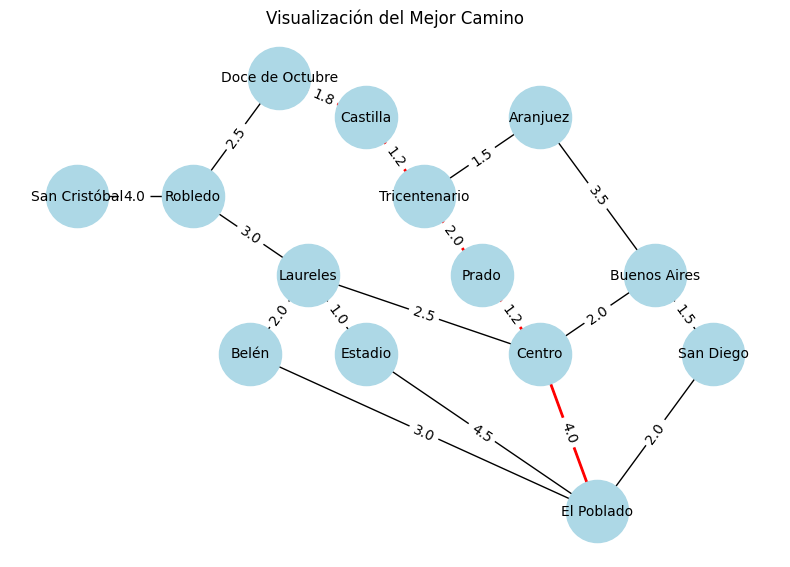

In [67]:
def main(verbose=True):
    start = "Doce de Octubre"
    goal = "El Poblado"
    print("\nBÚSQUEDA DE CAMINO ENTRE BARRIOS")
    print(f"Barrio de origen: {start}")
    print(f"Barrio de destino: {goal}\n")

    print("Ejecutando algoritmo A* (heurística euclidiana)...")
    res_a = a_star(GRAPH, start, goal, heuristic=euclidean_heuristic, verbose=verbose)
    print_result(res_a, "A* (Euclidiana)")

    print("Ejecutando algoritmo BFS (búsqueda en anchura, sin pesos)...")
    res_bfs = bfs(GRAPH, start, goal, verbose=verbose)
    print_result(res_bfs, "BFS (No ponderado)")

    graph = Graph()
    graph.create_from_dict(GRAPH)
    graph.draw_with_path(res_a["path"], pos=COORDS,  title="Visualización del Mejor Camino", result_path=None)


if __name__ == "__main__":
    main(verbose=True)